In [1]:
from scipy.io import loadmat
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score

2022-12-02 18:16:44.630799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 18:16:45.328749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 18:16:45.328779: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 18:16:45.404686: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 18:16:47.472884: W tensorflow/stream_executor/platform/defaul

#### Explore the data

In [2]:
data_train = loadmat('data/train_32x32.mat')
data_test = loadmat('data/test_32x32.mat')
type(data_train)  # dict
data_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
X_train_raw, y_train_raw = data_train['X'], data_train['y']
X_test_raw, y_test_raw = data_test['X'], data_test['y']
print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)


In [4]:
X_train, y_train = X_train_raw.transpose((3,0,1,2)), y_train_raw[:,0]
X_test, y_test = X_test_raw.transpose((3,0,1,2)), y_test_raw[:,0]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)


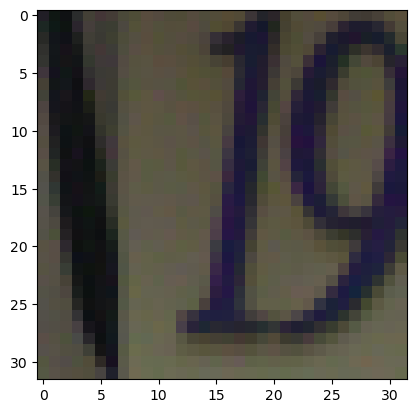

In [5]:
plt.imshow(X_train[0], cmap=plt.cm.gray)
plt.show()

In [6]:
max(y_test), min(y_test)

(10, 1)

#### Convert label '10' to '0' and to_categorical

In [7]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
max(y_test), min(y_test)

(9, 0)

In [8]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### VGG16 without fine tuning

Normalize the training data and adjust some brightness and location shift.

Preprocess the data with the `preprocess_input` function from VGG16.

In [25]:
train_generator1  = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    validation_split=0.15,
    brightness_range=[0.1, 0.7],
    width_shift_range=0.3, 
    height_shift_range=0.3,
    preprocessing_function=preprocess_input)

test_generator1  = ImageDataGenerator(preprocessing_function=preprocess_input)
# Since we need the mean and std of X_train to normalize it, train_generator1 should be fit by X_train
train_generator1.fit(X_train) 

In [26]:
BATCH_SIZE = 64
traingen1 = train_generator1.flow(X_train, y_train, subset = 'training', batch_size = BATCH_SIZE)
validgen1 = train_generator1.flow(X_train, y_train, subset = 'validation', batch_size = BATCH_SIZE)
# `shuffle=False` is important here. If not set so, the test set will shuffle when calculating the test accuracy.
testgen1 = test_generator1.flow(X_test, y_test, batch_size=1, shuffle=False)

Trained CNN with a pre-trained VGG16 with layers all frozen. Add to custum fully-connected layers to fit our dataset.

In [36]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0:
    # Load Imagenet weights.
    # Include_top=False means remove the model's linear layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    #conv_base = tf.keras.Sequential(conv_base.layers[:10])
    
    # Freeze layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Customize our own linear layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [30]:
input_shape = (32, 32, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10
n_steps = traingen1.n // BATCH_SIZE
n_val_steps = validgen1.n // BATCH_SIZE
n_epochs = 40

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [15]:
plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1_nofinetune.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

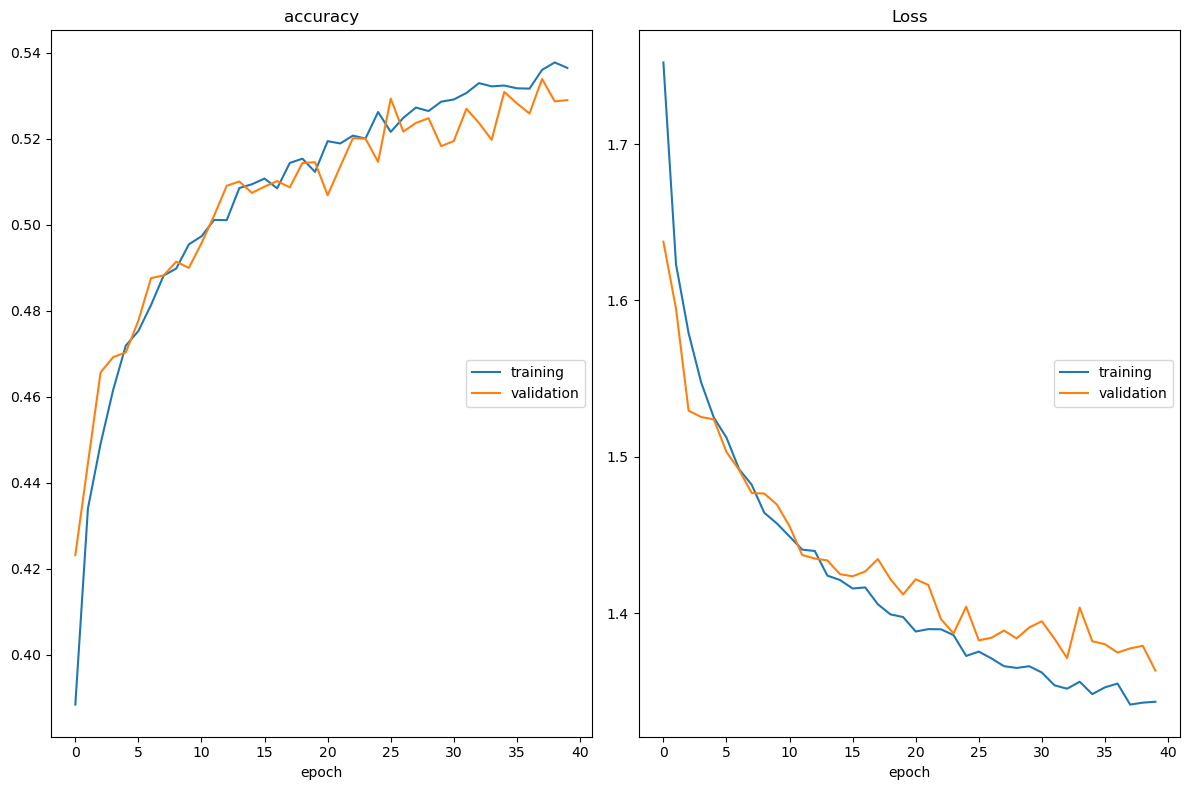

accuracy
	training         	 (min:    0.388, max:    0.538, cur:    0.536)
	validation       	 (min:    0.423, max:    0.534, cur:    0.529)
Loss
	training         	 (min:    1.342, max:    1.752, cur:    1.343)
	validation       	 (min:    1.363, max:    1.638, cur:    1.363)
972/972 [==============================] - 743s 764ms/step - loss: 1.3435 - accuracy: 0.5365 - val_loss: 1.3634 - val_accuracy: 0.5290


In [43]:
vgg_history = vgg_model.fit(traingen1,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen1,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss],
                            verbose=1)

In [31]:
vgg_model.load_weights('tl_model_v1_nofinetune.weights.best.hdf5')

In [32]:
true_classes = testgen1.y
true_classes = np.argmax(true_classes, axis=1)

vgg_preds = vgg_model.predict(testgen1)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

26032/26032 [==============================] - 784s 30ms/step


In [33]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 40.13%


## VGG16 with fine tuning

This time we only use the first 10 layers of VGG16 to eliminate the effect of the the training of imagenet.

We only froze the first 8 layers and retrain the last 2 layers.

Since the number of layers we are training now is increasing, to reduce the training time, we delete one fully-connected layer.

In [35]:
def create_model2(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    conv_base = tf.keras.Sequential(conv_base.layers[:10])
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    # top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

After searching for information, we found that digit detection is not sensitive to brightness and location shift, but to slight rotation. So we set the `rotation_range` as 30 and deleted brightness and locaton shift. Also we normalize the test data based on the mean and std of the training set.

In [10]:
train_generator2  = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    rotation_range=30,
    validation_split=0.15,
    preprocessing_function=preprocess_input)

test_generator2  = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    preprocessing_function=preprocess_input)
train_generator2.fit(X_train)
test_generator2.fit(X_train)

Increase the batch size to reduce training time.

In [46]:
BATCH_SIZE = 100
traingen2 = train_generator2.flow(X_train, y_train, subset = 'training', batch_size = BATCH_SIZE)
validgen2 = train_generator2.flow(X_train, y_train, subset = 'validation', batch_size = BATCH_SIZE)
# Again shuffle must be set as False
testgen2 = test_generator2.flow(X_test, y_test, batch_size=1, shuffle = False)

Create the model and train.

In [12]:
input_shape = (32, 32, 3)
optim_2 = Adam(learning_rate=0.0001)
n_classes=10
n_steps = traingen2.n // BATCH_SIZE
n_val_steps = validgen2.n // BATCH_SIZE
n_epochs = 10

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model2(input_shape, n_classes, optim_2, fine_tune=2)

2022-12-02 18:19:50.602621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 18:19:50.602971: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 18:19:50.603002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ubuntu-20): /proc/driver/nvidia/version does not exist
2022-12-02 18:19:50.603639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v2_10VGG16finetune2epoch10.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

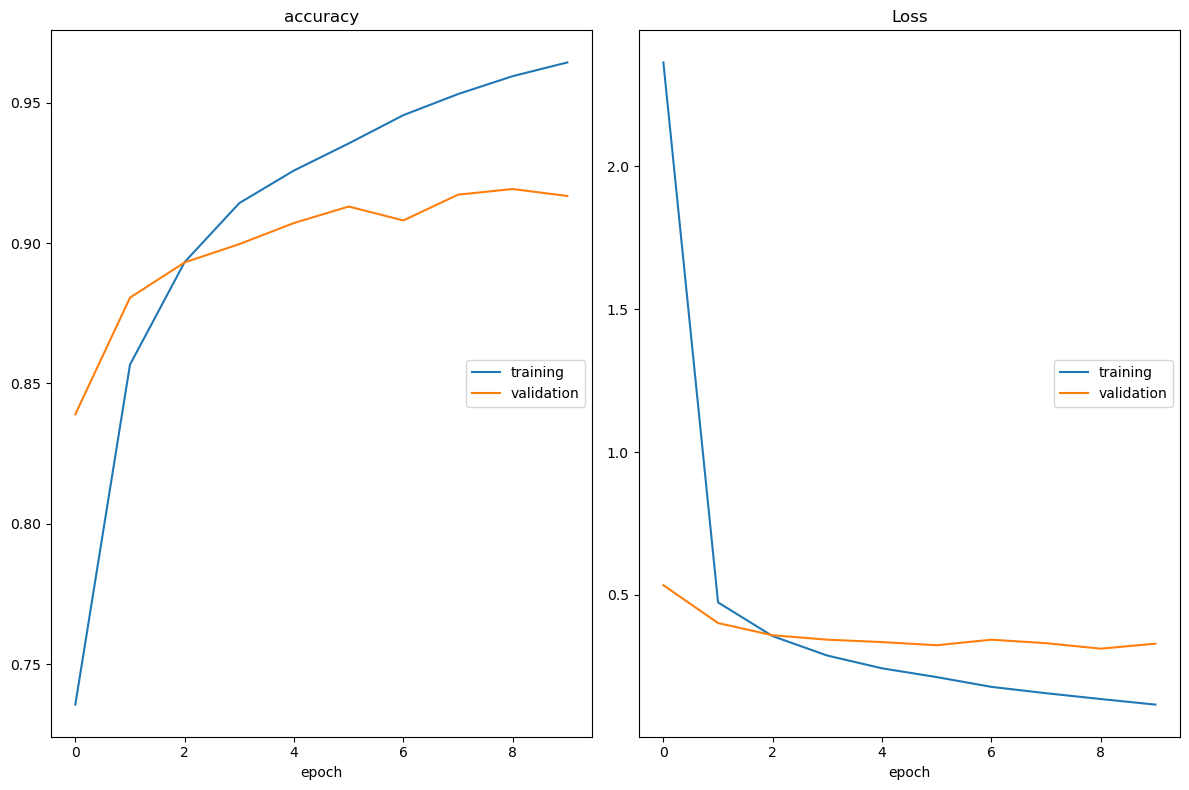

accuracy
	training         	 (min:    0.736, max:    0.964, cur:    0.964)
	validation       	 (min:    0.839, max:    0.919, cur:    0.917)
Loss
	training         	 (min:    0.116, max:    2.364, cur:    0.116)
	validation       	 (min:    0.312, max:    0.534, cur:    0.329)
622/622 [==============================] - 1845s 3s/step - loss: 0.1159 - accuracy: 0.9644 - val_loss: 0.3292 - val_accuracy: 0.9168


In [28]:
vgg_ft_history = vgg_model_ft.fit(traingen2,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen2,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_2, early_stop, plot_loss],
                                  verbose=1)

In [13]:
vgg_model_ft.load_weights('tl_model_v2_10VGG16finetune2epoch10.weights.best.hdf5')

In [21]:
true_classes2 = testgen2.y
true_classes2 = np.argmax(true_classes2, axis=1)

vgg_preds2 = vgg_model_ft.predict(testgen2)
vgg_pred_classes2 = np.argmax(vgg_preds2, axis=1)

26032/26032 [==============================] - 880s 34ms/step


In [22]:
vgg_acc2 = accuracy_score(true_classes2, vgg_pred_classes2)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc2 * 100))

VGG16 Model Accuracy with Fine-Tuning: 92.42%


Since we got a relatively more accurate model, we add the epoch to 30.

In [42]:
input_shape = (32, 32, 3)
optim_2 = Adam(learning_rate=0.0001)
n_classes=10
n_steps = traingen2.n // BATCH_SIZE
n_val_steps = validgen2.n // BATCH_SIZE
n_epochs = 30

vgg_model_ft2 = create_model2(input_shape, n_classes, optim_2, fine_tune=2)

In [38]:
tl_checkpoint_3 = ModelCheckpoint(filepath='tl_model_v3_10VGG16finetune2epoch30.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

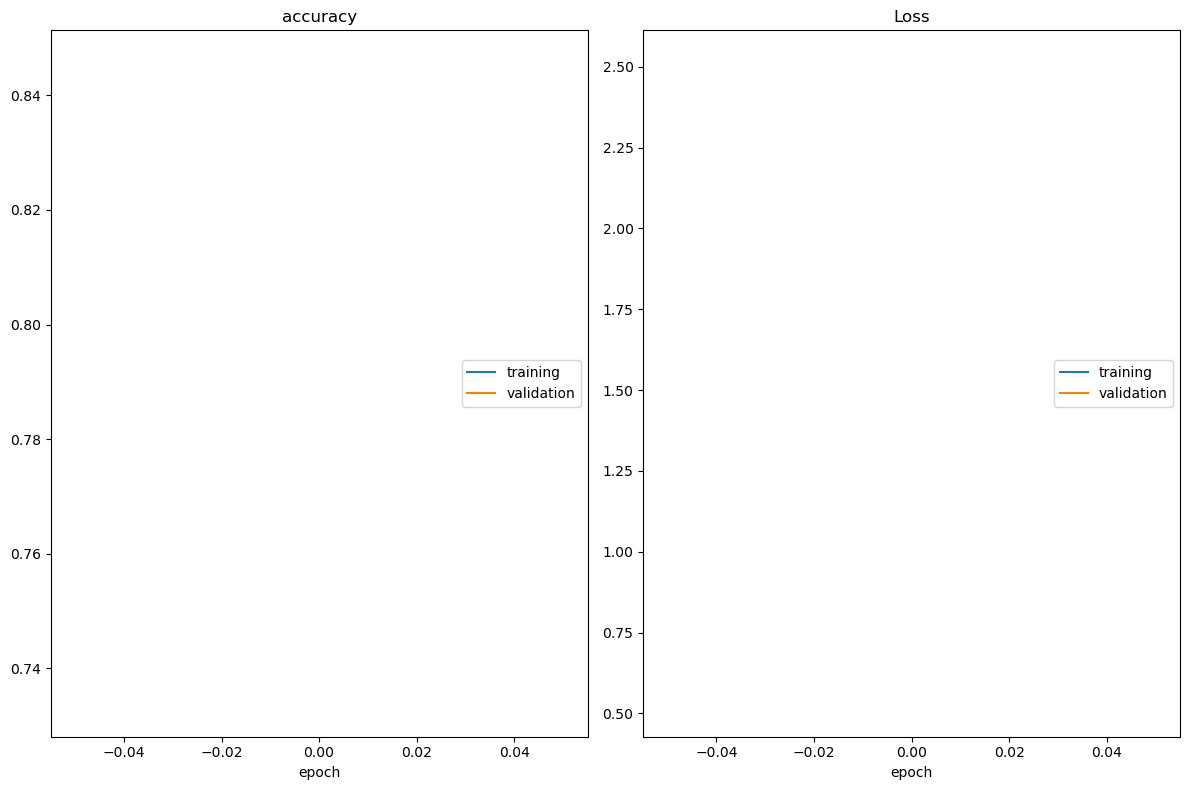

accuracy
	training         	 (min:    0.734, max:    0.734, cur:    0.734)
	validation       	 (min:    0.846, max:    0.846, cur:    0.846)
Loss
	training         	 (min:    2.513, max:    2.513, cur:    2.513)
	validation       	 (min:    0.527, max:    0.527, cur:    0.527)
972/972 [==============================] - 1667s 2s/step - loss: 2.5133 - accuracy: 0.7337 - val_loss: 0.5272 - val_accuracy: 0.8457


In [43]:
vgg_ft_history2 = vgg_model_ft2.fit(traingen2,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen2,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_3, early_stop, plot_loss],
                                  verbose=1)

In [44]:
vgg_model_ft2.load_weights('tl_model_v3_10VGG16finetune2epoch30.weights.best.hdf5')

In [47]:
true_classes3 = testgen2.y
true_classes3 = np.argmax(true_classes3, axis=1)

vgg_preds3 = vgg_model_ft2.predict(testgen2)
vgg_pred_classes3 = np.argmax(vgg_preds3, axis=1)


26032/26032 [==============================] - 849s 33ms/step
VGG16 Model Accuracy with Fine-Tuning Epoch 30: 86.00%


In [48]:
vgg_acc3 = accuracy_score(true_classes3, vgg_pred_classes3)
print("VGG16 Model Accuracy with Fine-Tuning Epoch 30: {:.2f}%".format(vgg_acc3 * 100))

VGG16 Model Accuracy with Fine-Tuning Epoch 30: 86.00%
